# CBCT calibration development notebook

## Load needed modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# from skimage.morphology import label
# from skimage.morphology import thin
# from skimage.measure import regionprops
# from skimage.measure import EllipseModel
# import cv2

import sys
sys.path.append('/Users/kaestner/git/scripts/python/')
import amglib.readers as io
sys.path.append('../')
import cbct.CBCT_Calibration as cbct
import amglib.plotsupport as pltsp

import importlib

## Load the data


In [ ]:
datapath = '/Volumes/ExtremePro/data/P20240130_1/02_rawdata/00_setup/cbct-cal/'
dc=io.read_images(datapath+'dc_{:05}.fits',first=1,last=5,averageStack=True,average='mean');
ob=io.read_images(datapath+'ob_{:05}.fits',first=1,last=5,averageStack=True,average='mean');
proj=io.read_images(datapath+'ct_{:05}.fits',first=1,last=360,stride=10)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

## Data preparation
- Create an instance of the CBCT_Calibration class
- Set the dark current and open beam images
- Set the calibration images
- Normalize
- Threshold

### Processing to obtain ellipses

Create a calibration instance and provide the reference images. It is possible to vertically flip the projection if needed. This is to guarantee that the first ellipse is complete inside the image. A requirement for the following analysis. 

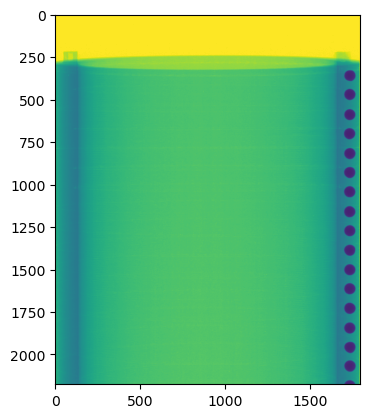

In [5]:
importlib.reload(cbct)  
cal = cbct.CBCTCalibration()
cal.set_projections(proj=proj,ob=ob,dc=dc,verticalflip=True,show=True)


#### Remove the baseline 
Removing the projection baseline from the calibration sample is needed to make the thresholing easier. There are two alternatives depending on the sample type
- ```remove_projection_baseline()``` works well for hollow calibration samples
- ```flatten_projections()``` works well for solid samples, in particular when they are a little tilted.

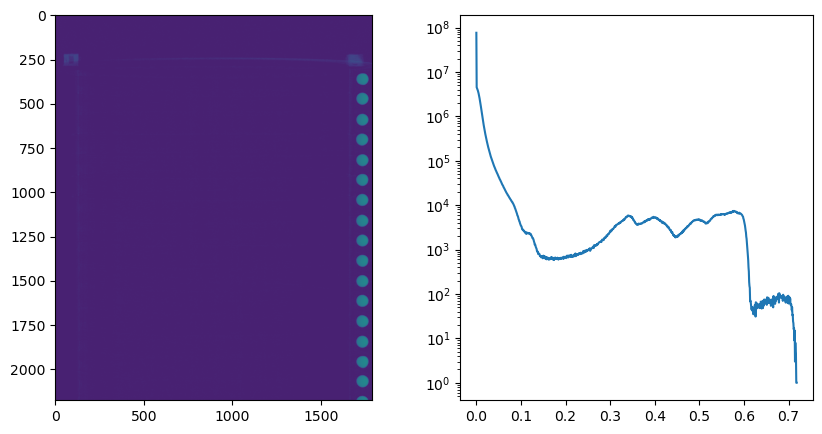

In [6]:
cal.remove_projection_baseline(show=True)

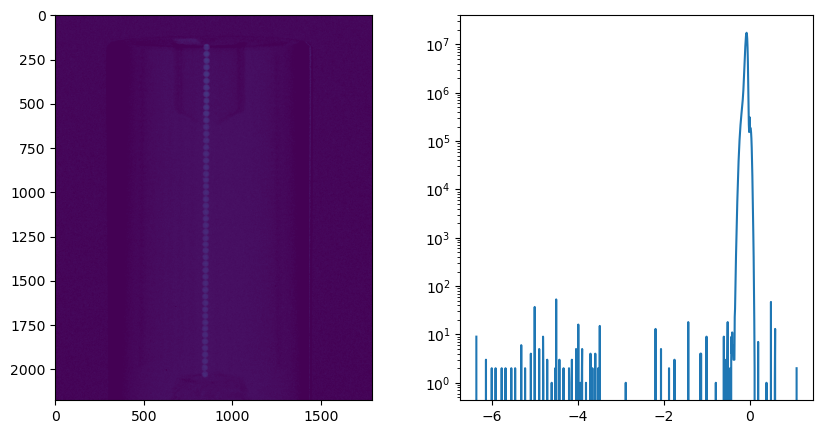

In [ ]:
cal.flatten_projections(amplification=10, stack_window=5,show=True)

#### Thresholding the projections
The thresholding binarizes the projections and also removes items connected to the image border.
Otsu thresholding is used when the threshold parameter is set to _None_, otherwise the threshold value is used.

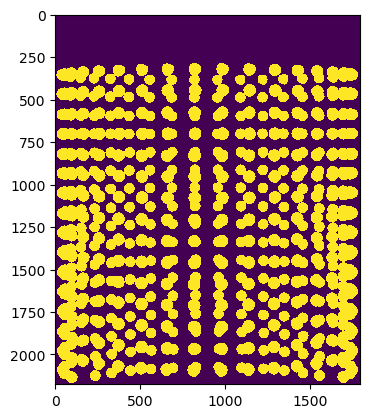

In [7]:
cal.threshold_projections(threshold=None, show=True,clearborder=True)

#### Finding the beads and fit ellipses
The following three calls provide parameterized ellipses from the binary image.
1. Find beads labels the beads. The breakup parameter cuts the connected chain of beads into separate items. Don't use if the beads are already separated.
2. Connect beads between the projections into bead trajectories.
3. Finally, fit the bead positions to an ellipse model

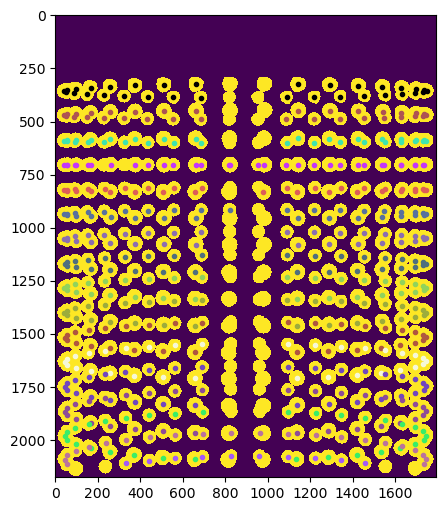

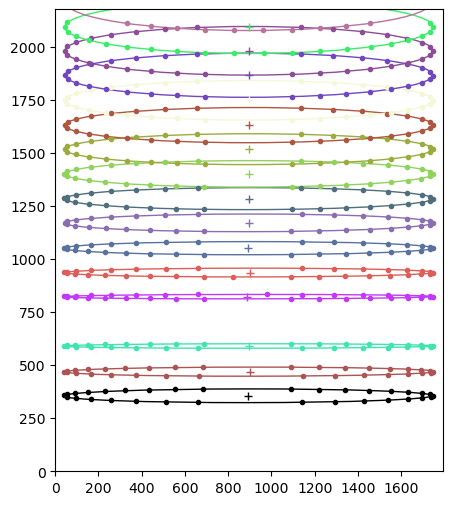

In [ ]:
cal.find_beads(breakup=False,show=False)
cal.find_trajectories(show=True)
cal.fit_ellipses(show=True,prune=True)
e=cal.ellipses

### Compute the calibration geometry for the setup

{'COR': {'center': 894.1203781136825,
  'slope': 0.0005994398197631155,
  'tilt': 0.034345367630757795},
 'SDD': -1323.2880328237466,
 'SOD': -111.9222905824153,
 'pp': {'y': 703.5642229547572, 'x': array([   0.17877883, -125.9538825 ])},
 'MAG': 11.833559627916406}

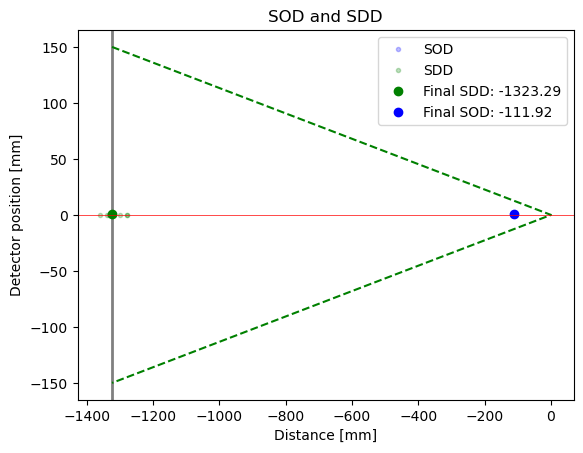

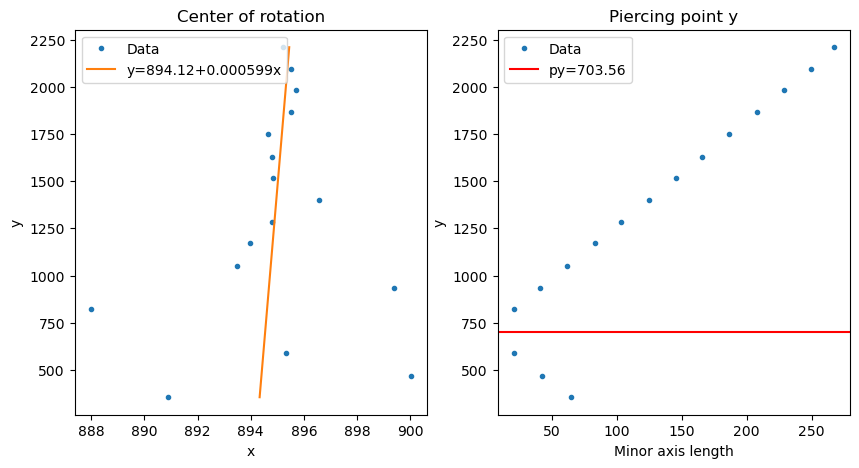

In [ ]:
importlib.reload(cbct)

cal = cbct.CBCTCalibration()
cal.ellipses=e
cal.compute_calibration(diameter=20,avgtype='mean', remove_outliers=True,show=True)

cal.calibration